# Setup

In [1]:
DATA_FILE_NAME = "consultation-documents-preprocessed-2025-02-11.parquet"
EXTRA_DOCUMENT_FEATURES_FILE_NAME = "consultation-documents-features-2025-02-05.parquet"

LANGUAGES = {
    "de",
    # "fr",
    # "it",
}

# EMBEDDING_MODEL = "openai/text-embedding-ada-002"
EMBEDDING_MODEL = "openai/text-embedding-3-large"

# FROM_YEAR = 2010
FROM_YEAR = 2000

MERGE_CLASSES = {
    # (classes, to, drop): replacement_class
    # ("RESPONSE_FORM", "SURVEY", "SYNOPTIC_TABLE", "VARIOUS_TEXT"): "VARIOUS_TEXT",
}

INCLUDE_RULE_LABELS_IN_TRAINING = {
    # "REPORT",
    "SYNOPTIC_TABLE",
    "LETTER",
}

CV_FOLDS = 5
TEST_SIZE = 0.1
RANDOM_STATE = 2718
USE_TEST_SET = True

In [2]:
%load_ext autoreload
%autoreload 2

import logging
import os
import pathlib
import sys
from typing import Any

import dotenv
import matplotlib.pyplot as plt
import mlflow
import numpy as np
import pandas as pd
import sklearn.metrics
import sklearn.model_selection
import sklearn.utils.multiclass
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA
from sklearn.ensemble import GradientBoostingClassifier  # noqa: F401
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler  # noqa: F401
from tqdm import tqdm

REPOSITORY_ROOT = (pathlib.Path().cwd() / ".." / "..").resolve()
sys.path.append(str(REPOSITORY_ROOT))

In [3]:
from demokratis_ml.data import schemata
from research.document_types import document_title_rule_model
from research.lib import data_access, embeddings, plotting

In [4]:
dotenv.load_dotenv()

True

In [5]:
if os.environ.get("MLFLOW_TRACKING_USERNAME") and os.environ.get("MLFLOW_TRACKING_PASSWORD"):
    mlflow.set_tracking_uri("https://mlflow.ml1.demokratis.ch/")
else:
    logging.warning("MLflow credentials not found, will track locally.")
    mlflow.set_tracking_uri("sqlite:///mlruns.db")

mlflow.set_experiment("VM_document_type_classifier")

if run := mlflow.active_run():
    logging.warning("Run = %s is already active, closing it.", run.info.run_name)
    mlflow.end_run()
run = mlflow.start_run()
print("Starting run:", run.info.run_name)
mlflow.log_param("input_file", DATA_FILE_NAME)
mlflow.log_param("languages", LANGUAGES)
mlflow.log_param("from_year", FROM_YEAR)
mlflow.log_param("embedding_model", EMBEDDING_MODEL)
mlflow.log_param("cv_folds", CV_FOLDS)
mlflow.log_param("test_size", TEST_SIZE)
mlflow.log_param("random_state", RANDOM_STATE)
;

2025/03/04 17:48:20 INFO mlflow.tracking.fluent: Experiment with name 'VM_document_type_classifier' does not exist. Creating a new experiment.


Starting run: crawling-skunk-963


''

In [6]:
mlflow.sklearn.autolog()
tqdm.pandas()

2025/03/04 17:48:31 WARNING mlflow.utils.autologging_utils: MLflow sklearn autologging is known to be compatible with 0.24.1 <= scikit-learn <= 1.5.2, but the installed version is 1.6.0. If you encounter errors during autologging, try upgrading / downgrading scikit-learn to a compatible version, or try upgrading MLflow.


# Input data preparation

In [7]:
def merge_classes(series: pd.Series) -> pd.Series:
    """Apply the MERGE_CLASSES setting to a series of document type labels."""
    series = series.copy()
    for old_classes, new_class in MERGE_CLASSES.items():
        mask = series.isin(old_classes)
        series.loc[mask] = new_class
    return series

In [8]:
PREPROCESSED_DATA_FILE = REPOSITORY_ROOT / "data" / "dataframes" / DATA_FILE_NAME
data_access.ensure_dataframe_is_available(PREPROCESSED_DATA_FILE)

## Load the external test set (manually labelled)

In [9]:
df_test_external = pd.read_excel(REPOSITORY_ROOT / "research" / "document_types" / "ground_truth.xlsx")[
    ["document_id", "ground_truth"]
].set_index("document_id")
df_test_external["ground_truth"] = pd.Categorical(df_test_external["ground_truth"], categories=schemata.DOCUMENT_TYPES)
df_test_external["ground_truth"] = merge_classes(df_test_external["ground_truth"])
df_test_external = df_test_external.dropna()
df_test_external

,ground_truth
document_id,
43657,FINAL_REPORT
40411,REPORT
43681,DRAFT
46685,RECIPIENT_LIST
40706,RECIPIENT_LIST
...,...
45231,LETTER
45040,DRAFT
40646,LETTER


## Load Fedlex data (all of it is used for training)

In [10]:
df_fedlex = data_access.load_consultation_documents(
    PREPROCESSED_DATA_FILE,
    only_document_sources={"fedlex"},
    only_languages=LANGUAGES,
    starting_year=FROM_YEAR,
    mlflow=mlflow,
)
df_fedlex

,document_id,consultation_id,consultation_start_date,consultation_end_date,consultation_title,consultation_description,document_source_url,consultation_url,consultation_topics,document_type,document_language,document_title,organisation_id,organisation_name,political_body,consultation_reviewed_at,document_source,consultation_topics_label_source,document_content_plain
0,1,1,2021-10-01,2022-01-17,Verordnung des BAZG über die Bekämpfung von G...,Mit der am 19. März 2021 durch das Parlament b...,https://fedlex.data.admin.ch/filestore/fedlex....,https://www.demokratis.ch/vernehmlassung/7bt3hz2w,"[administration, finance, security]",DRAFT,de,Vernehmlassungsvorlage,41,Bundesamt für Zoll und Grenzsicherheit,ch,2024-11-04 15:11:24,fedlex,manual,«$$e-seal» \n«$$QrCode» \n \n2021-… \n«%ASFF_Y...
3,4,1,2021-10-01,2022-01-17,Verordnung des BAZG über die Bekämpfung von G...,Mit der am 19. März 2021 durch das Parlament b...,https://fedlex.data.admin.ch/filestore/fedlex....,https://www.demokratis.ch/vernehmlassung/7bt3hz2w,"[administration, finance, security]",RECIPIENT_LIST,de,Adressatenliste,41,Bundesamt für Zoll und Grenzsicherheit,ch,2024-11-04 15:11:24,fedlex,manual,Eidgenössisches Finanzdepartement EFD \nEidgen...
6,7,1,2021-10-01,2022-01-17,Verordnung des BAZG über die Bekämpfung von G...,Mit der am 19. März 2021 durch das Parlament b...,https://fedlex.data.admin.ch/filestore/fedlex....,https://www.demokratis.ch/vernehmlassung/7bt3hz2w,"[administration, finance, security]",LETTER,de,Begleitschreiben 2,41,Bundesamt für Zoll und Grenzsicherheit,ch,2024-11-04 15:11:24,fedlex,manual,Eidgenössisches Finanzdepartement EFD \nEidgen...
9,10,1,2021-10-01,2022-01-17,Verordnung des BAZG über die Bekämpfung von G...,Mit der am 19. März 2021 durch das Parlament b...,https://fedlex.data.admin.ch/filestore/fedlex....,https://www.demokratis.ch/vernehmlassung/7bt3hz2w,"[administration, finance, security]",REPORT,de,Erläuternder Bericht,41,Bundesamt für Zoll und Grenzsicherheit,ch,2024-11-04 15:11:24,fedlex,manual,1. Oktober 2021 \n \n \n \n \nVerordnung des B...
12,13,1,2021-10-01,2022-01-17,Verordnung des BAZG über die Bekämpfung von G...,Mit der am 19. März 2021 durch das Parlament b...,https://fedlex.data.admin.ch/filestore/fedlex....,https://www.demokratis.ch/vernehmlassung/7bt3hz2w,"[administration, finance, security]",LETTER,de,Begleitschreiben 1,41,Bundesamt für Zoll und Grenzsicherheit,ch,2024-11-04 15:11:24,fedlex,manual,Eidgenössisches Finanzdepartement EFD \nEidgen...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52393,54034,5032,2025-02-07,2025-05-16,20.490 n Pa. Iv. Hurni. Pharmazeutische Indust...,Die Kommission für soziale Sicherheit und Gesu...,https://fedlex.data.admin.ch/filestore/fedlex....,https://www.demokratis.ch/vernehmlassung/ypv7fa4f,"[economics, health]",LETTER,de,Begleitschreiben,86,Parlamentsdienste,ch,2025-02-10 14:15:51,fedlex,manual,Na t i o na l r at \nCo n s e il na t io n a...
52396,54037,5032,2025-02-07,2025-05-16,20.490 n Pa. Iv. Hurni. Pharmazeutische Indust...,Die Kommission für soziale Sicherheit und Gesu...,https://fedlex.data.admin.ch/filestore/fedlex....,https://www.demokratis.ch/vernehmlassung/ypv7fa4f,"[economics, health]",LETTER,de,Begleitschreiben-2,86,Parlamentsdienste,ch,2025-02-10 14:15:51,fedlex,manual,Na t i o na l r at \nCo n s e il na t io n a...
52399,54040,5032,2025-02-07,2025-05-16,20.490 n Pa. Iv. Hurni. Pharmazeutische Indust...,Die Kommission für soziale Sicherheit und Gesu...,https://fedlex.data.admin.ch/filestore/fedlex....,https://www.demokratis.ch/vernehmlassung/ypv7fa4f,"[economics, health]",RECIPIENT_LIST,de,Adressatenliste,86,Parlamentsdienste,ch,2025-02-10 14:15:51,fedlex,manual,1 \nVernehmlassung zur Parlamentarischen Initi...
52402,54043,5032,2025-02-07,2025-05-16,20.490 n Pa. Iv. Hurni. Pharmazeutische Indust...,Die Kommission für soziale Sicherheit und Gesu...,https://fedlex.data.admin.ch/filestore/fedlex....,https://www.demokratis.ch/vernehmlassung/

## Load OpenParlData and generate labels by the rule model

In [11]:
df_opd = data_access.load_consultation_documents(
    PREPROCESSED_DATA_FILE,
    only_document_sources={"openparldata"},
    only_languages=LANGUAGES,
    starting_year=FROM_YEAR,
    mlflow=mlflow,
)
df_opd

,document_id,consultation_id,consultation_start_date,consultation_end_date,consultation_title,consultation_description,document_source_url,consultation_url,consultation_topics,document_type,document_language,document_title,organisation_id,organisation_name,political_body,consultation_reviewed_at,document_source,consultation_topics_label_source,document_content_plain
38324,38325,2283,2019-05-09,2019-08-12,Auflösung NOK-Gründungsvertrag; Energiegesetz ...,Der NOK-Gründungsvertrag aus dem Jahr 1914 ist...,https://www.ag.ch/media/kanton-aargau/portal/a...,https://www.demokratis.ch/vernehmlassung/5cckh63y,"[administration, economics, energy]",NaN,de,Beilage 1 zum Anhörungsbericht (Statuten) (PDF...,141,Regierungsrat des Kantons Aargau,ag,2025-02-04 12:39:48,openparldata,manual,Beilage 1 \nVerabschiedet durch Politisches Gr...
38325,38326,2283,2019-05-09,2019-08-12,Auflösung NOK-Gründungsvertrag; Energiegesetz ...,Der NOK-Gründungsvertrag aus dem Jahr 1914 ist...,https://www.ag.ch/media/kanton-aargau/portal/a...,https://www.demokratis.ch/vernehmlassung/5cckh63y,"[administration, economics, energy]",NaN,de,Beilage 2 zum Anhörungsbericht (Aktionärbindun...,141,Regierungsrat des Kantons Aargau,ag,2025-02-04 12:39:48,openparldata,manual,"Stand: 20. November 2018, mit formalen Ergänzu..."
38326,38327,2283,2019-05-09,2019-08-12,Auflösung NOK-Gründungsvertrag; Energiegesetz ...,Der NOK-Gründungsvertrag aus dem Jahr 1914 ist...,https://www.ag.ch/media/kanton-aargau/portal/a...,https://www.demokratis.ch/vernehmlassung/5cckh63y,"[administration, economics, energy]",NaN,de,Beilage 3 zum Anhörungsbericht (Eignerstrategi...,141,Regierungsrat des Kantons Aargau,ag,2025-02-04 12:39:48,openparldata,manual,Seite 1 von 2 Stand: 20. November 2018 \n\nEig...
38327,38328,2283,2019-05-09,2019-08-12,Auflösung NOK-Gründungsvertrag; Energiegesetz ...,Der NOK-Gründungsvertrag aus dem Jahr 1914 ist...,https://www.ag.ch/media/kanton-aargau/portal/a...,https://www.demokratis.ch/vernehmlassung/5cckh63y,"[administration, economics, energy]",NaN,de,Beilage 4 zum Anhörungsbericht (NOK-Gründungsv...,141,Regierungsrat des Kantons Aargau,ag,2025-02-04 12:39:48,openparldata,manual,731.120\n\nSchaffhauser Rechtsbuch 1997 1\n\nV...
38328,38329,2283,2019-05-09,2019-08-12,Auflösung NOK-Gründungsvertrag; Energiegesetz ...,Der NOK-Gründungsvertrag aus dem Jahr 1914 ist...,https://www.ag.ch/media/kanton-aargau/portal/a...,https://www.demokratis.ch/vernehmlassung/5cckh63y,"[administration, economics, energy]",NaN,de,"Anhörungsbericht (PDF, 10 Seiten, 184 KB)",141,Regierungsrat des Kantons Aargau,ag,2025-02-04 12:39:48,openparldata,manual,J:\03_Geschäfte\1_Vorträge\05_AE\Auflösung NOK...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52413,54054,5033,2025-02-05,2025-04-22,Alle Unterlagen zum Massnahmenpaket 2024,Am 13. Dezember 2023 reichte die CVP - Die Mit...,https://www.ur.ch/_doc/406750,https://www.demokratis.ch/vernehmlassung/gr5vsavt,[public_finance],VARIOUS_TEXT,de,Anhang 6 Massnahmen E Mehrerträge,162,Regierungsrat des Kantons Uri,ur,2025-02-10 14:28:56,openparldata,manual,Massnahmen E: Mehrerträge Anhang 6\nErfolgsrec...
52414,54055,5033,2025-02-05,2025-04-22,Alle Unterlagen zum Massnahmenpaket 2024,Am 13. Dezember 2023 reichte die CVP - Die Mit...,https://www.ur.ch/_doc/406753,https://www.demokratis.ch/vernehmlassung/gr5vsavt,[public_finance],VARIOUS_TEXT,de,Anhang 7 Massnahmen F Nettoinvestitionen,162,Regierungsrat des Kantons Uri,ur,2025-02-10 14:28:56,openparldata,manual,Massnahmen F: Nettoinvestitionen Anhang 7\nErf...
52415,54056,5033,2025-02-05,2025-04-22,Alle Unterlagen zum Massnahmenpaket 2024,Am 13. Dezember 2023 reichte die CVP - Die Mit...,https://www.ur.ch/_doc/406756,https://www.demokratis.ch/vernehmlassung/gr5vsavt,[public_finance],VARIOUS_TEXT,de,Anhang 8 Massnahmen mit kleiner 50 TCHF,162,Regierungsrat des Kantons Uri,ur,2025-02-10 14:28:56,openparldata,manual,Anhang 8\nMassnahmen mit einer kumulierten Wir...
52416,5405

In [12]:
# Generate rule-labels (predictions)
df_opd["prediction_rule"] = document_title_rule_model.predict(df_opd)

# Split OpenParlData: only pick certain rule-labels for training.
opd_train_index = (
    # Only pick certain rule-labels for training...
    df_opd["prediction_rule"].isin(INCLUDE_RULE_LABELS_IN_TRAINING)
    # ...but make sure we don't train on documents that are in the external test set.
    & ~df_opd["document_id"].isin(df_test_external.index)
)
df_opd_train = df_opd.loc[opd_train_index].copy()
df_opd_test = df_opd.loc[~opd_train_index].copy()
del df_opd  # Prevent mistakes; we should only explicitly access the train or the test set from now on.

# Normalise the training portion: use the rule-label as the canonical target label.
del df_opd_train["document_type"]
df_opd_train = df_opd_train.rename(columns={"prediction_rule": "document_type"})

print(f"Adding {len(df_opd_train)} OpenParlData documents to the training set:")
df_opd_train["document_type"].value_counts(dropna=False)

Adding 2253 OpenParlData documents to the training set:


document_type
LETTER            1551
SYNOPTIC_TABLE     702
DECISION             0
DRAFT                0
FINAL_REPORT         0
LINK                 0
OPINION              0
RECIPIENT_LIST       0
REPORT               0
RESPONSE_FORM        0
SURVEY               0
VARIOUS_TEXT         0
Name: count, dtype: int64

## Create the input dataframe from Fedlex and a part of OpenParlData

In [13]:
df_input = pd.concat([df_fedlex, df_opd_train], ignore_index=True)

In [14]:
# Make sure we didn't lose the correct categorical type when merging dataframes.
assert set(df_input["document_type"].cat.categories) == schemata.DOCUMENT_TYPES

df_input["document_type"].value_counts(dropna=False)

document_type
LETTER            4653
DRAFT             2912
REPORT            2163
RECIPIENT_LIST    1780
FINAL_REPORT      1754
OPINION            996
SYNOPTIC_TABLE     790
VARIOUS_TEXT       418
SURVEY              15
RESPONSE_FORM        7
DECISION             0
LINK                 0
Name: count, dtype: int64

## Merge classes

In [15]:
df_input["document_type"] = merge_classes(df_input["document_type"])
df_input["document_type"].value_counts(dropna=False)

document_type
LETTER            4653
DRAFT             2912
REPORT            2163
RECIPIENT_LIST    1780
FINAL_REPORT      1754
OPINION            996
SYNOPTIC_TABLE     790
VARIOUS_TEXT       418
SURVEY              15
RESPONSE_FORM        7
DECISION             0
LINK                 0
Name: count, dtype: int64

## Drop empty documents

In [16]:
def drop_empty_texts(df: pd.DataFrame) -> pd.DataFrame:
    empty_index = df["document_content_plain"].str.strip() == ""
    empty_count = len(df[empty_index])
    print(f"Empty texts: {empty_count} ({100 * empty_count / len(df):.1f}%)")
    return df.loc[~empty_index]


print("df_input:", end=" ")
df_input = drop_empty_texts(df_input)
print("df_opd_test:", end=" ")
df_opd_test = drop_empty_texts(df_opd_test)

df_input: Empty texts: 997 (6.4%)
df_opd_test: Empty texts: 266 (3.5%)


## Additional features

In [17]:
FEATURES_DATA_FILE = REPOSITORY_ROOT / "data" / "dataframes" / EXTRA_DOCUMENT_FEATURES_FILE_NAME
data_access.ensure_dataframe_is_available(FEATURES_DATA_FILE)

df_features = pd.read_parquet(FEATURES_DATA_FILE)
df_features

,count_pages,count_pages_containing_tables,average_page_aspect_ratio
document_id,,,
1,26.0,0.0,0.704898
2,26.0,0.0,0.704898
3,25.0,0.0,0.704898
4,6.0,0.0,0.707098
5,6.0,0.0,0.707098
...,...,...,...
53789,1.0,0.0,0.707098
53790,10.0,0.0,0.704697
53791,2.0,0.0,0.707157


In [18]:
def add_features(df: pd.DataFrame) -> pd.DataFrame:
    previous_shape = df.shape
    df = df.join(df_features, on="document_id", how="inner")
    df["fraction_pages_containing_tables"] = df["count_pages_containing_tables"] / df["count_pages"]
    df["contains_synopse_keyword"] = (
        df["document_content_plain"].str.slice(0, 1000).str.contains("synopse", case=False, regex=False)
    )
    df["contains_salutation"] = (
        df["document_content_plain"]
        .str.slice(0, 3000)
        .str.contains(
            r"(?:Sehr\s+geehrte[r]?\s+(?:Frau|Herr|Damen\s+und\s+Herren)|"
            r"Liebe[r]?\s+(?:Frau|Herr|Damen\s+und\s+Herren)|"
            r"Sehr\s+geehrte[r]?\s+(?:"
            r"Bundesr(?:at|ätin)|"
            r"Regierungsr(?:at|ätin)|"
            r"Nationalr(?:at|ätin)|"
            r"Stadtpr[äa]sid(?:ent|entin)|"
            r"Gemeindepr[äa]sid(?:ent|entin)|"
            r"Stadtr(?:at|ätin)|"
            r"Gemeinder(?:at|ätin)|"
            r"Pr[äa]sid(?:ent|entin)))",
            case=False,
            regex=True,
        )
    )
    print(
        f"{previous_shape[0] - df.shape[0]} rows were lost due to missing features. Remaining rows: {df.shape[0]}. "
        f"{df.shape[1] - previous_shape[1]} columns were added."
    )
    return df

In [19]:
df_input = add_features(df_input)
df_opd_test = add_features(df_opd_test)

622 rows were lost due to missing features. Remaining rows: 13869. 6 columns were added.
1565 rows were lost due to missing features. Remaining rows: 5837. 6 columns were added.


/var/folders/zq/k8fwbncx1vg2swbktbl1t4z00000gp/T/ipykernel_53397/3258523438.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  counts = df.groupby("document_type")[feature_name].value_counts(normalize=True) * 100
/var/folders/zq/k8fwbncx1vg2swbktbl1t4z00000gp/T/ipykernel_53397/3258523438.py:3: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  pivot_table = counts.reset_index(name="percentage").pivot_table(


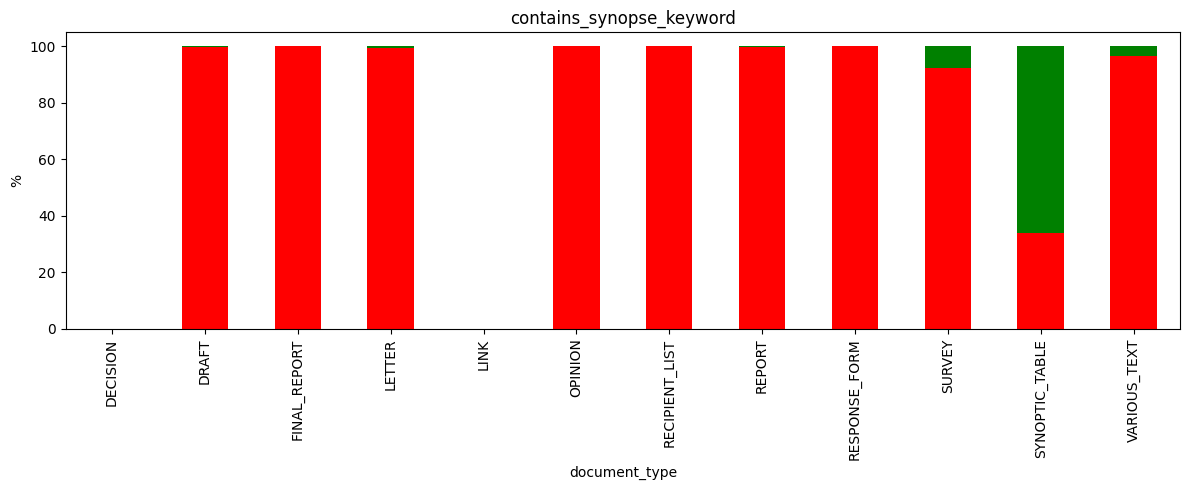

/var/folders/zq/k8fwbncx1vg2swbktbl1t4z00000gp/T/ipykernel_53397/3258523438.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  counts = df.groupby("document_type")[feature_name].value_counts(normalize=True) * 100
/var/folders/zq/k8fwbncx1vg2swbktbl1t4z00000gp/T/ipykernel_53397/3258523438.py:3: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  pivot_table = counts.reset_index(name="percentage").pivot_table(


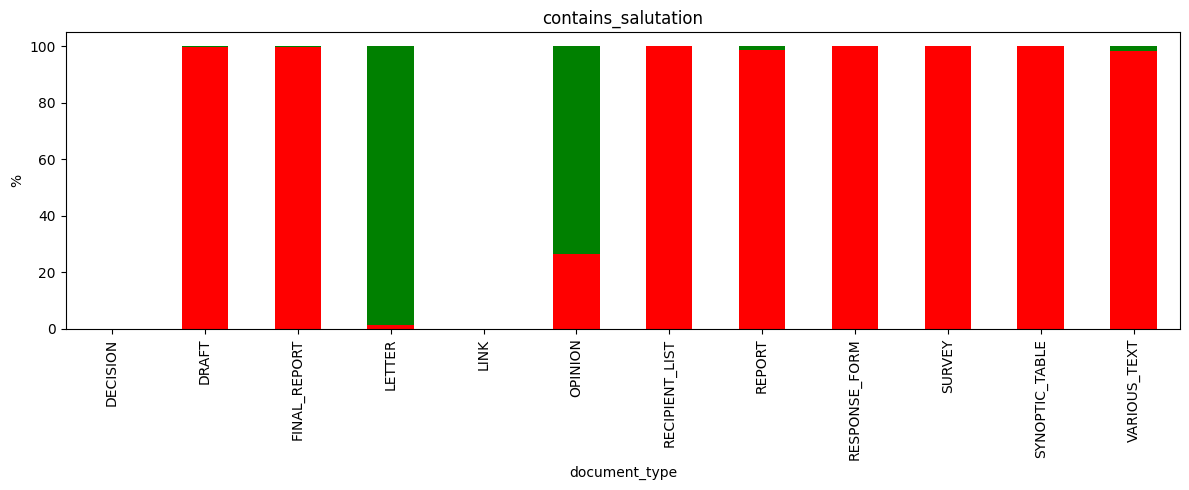

In [20]:
def plot_feature_across_document_types(df: pd.DataFrame, feature_name: str) -> None:
    counts = df.groupby("document_type")[feature_name].value_counts(normalize=True) * 100
    pivot_table = counts.reset_index(name="percentage").pivot_table(
        index="document_type", columns=feature_name, values="percentage", aggfunc="sum"
    )
    pivot_table.plot(
        kind="bar",
        stacked=True,
        color=["r", "g"],
        figsize=(12, 5),
        legend=False,
        title=feature_name,
        ylabel="%",
    )
    plt.tight_layout()
    plt.show()


plot_feature_across_document_types(df_input, "contains_synopse_keyword")
plot_feature_across_document_types(df_input, "contains_salutation")

In [21]:
df_opd_test.groupby("document_type")["contains_synopse_keyword"].value_counts(normalize=True) * 100

/var/folders/zq/k8fwbncx1vg2swbktbl1t4z00000gp/T/ipykernel_53397/2192545349.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_opd_test.groupby("document_type")["contains_synopse_keyword"].value_counts(normalize=True) * 100


document_type   contains_synopse_keyword
DECISION        False                         0.000000
                True                          0.000000
DRAFT           False                        86.363636
                True                         13.636364
FINAL_REPORT    False                         0.000000
                True                          0.000000
LETTER          False                       100.000000
                True                          0.000000
LINK            False                         0.000000
                True                          0.000000
OPINION         False                         0.000000
                True                          0.000000
RECIPIENT_LIST  False                       100.000000
                True                          0.000000
REPORT          False                        93.333333
                True                          6.666667
RESPONSE_FORM   False                         0.000000
                True    

## Splits

### Set aside a test set

In [22]:
splitter = sklearn.model_selection.StratifiedShuffleSplit(
    n_splits=1,
    test_size=TEST_SIZE,
    random_state=RANDOM_STATE,
)

train_index, test_index = next(splitter.split(X=df_input, y=df_input["document_type"]))

In [23]:
df_input_train = df_input.iloc[train_index]
df_input_test = df_input.iloc[test_index]

print("Train:", df_input_train.shape)
print("Test:", df_input_test.shape)

Train: (12482, 25)
Test: (1387, 25)


In [24]:
mlflow.log_param("train_samples_count", len(df_input_train))
mlflow.log_param("test_samples_count", len(df_input_test))

1387

### Prepare a cross-validation splitter

In [25]:
cv_splitter = sklearn.model_selection.StratifiedKFold(
    n_splits=CV_FOLDS,
    shuffle=True,
    random_state=RANDOM_STATE,
)

# Embeddings

## Tokenise and truncate to input window

In [26]:
embedding_model = embeddings.create_embedding_model(EMBEDDING_MODEL)
mlflow.log_param("embedding_model.max_input_tokens", embedding_model.max_input_tokens)

tokens_train = df_input_train["document_content_plain"].progress_map(embedding_model.tokenize)
tokens_test = df_input_test["document_content_plain"].progress_map(embedding_model.tokenize)

100%|██████████| 1387/1387 [00:04<00:00, 282.44it/s]


## Embed

In [27]:
with embeddings.use_cache(
    embedding_model,
    tqdm=tqdm,
    cache_directory=REPOSITORY_ROOT / "data" / "embeddings-cache",
    read_only=False,
) as get_embeddings:
    embeddings_train = get_embeddings(tokens_train.tolist())
    print(embeddings_train.shape)
    embeddings_test = get_embeddings(tokens_test.tolist())
    print(embeddings_test.shape)

Embedding (cached=12481, new=0): 100%|██████████| 12482/12482 [00:10<00:00, 1215.74it/s]


(12482, 3072)


Embedding (cached=1386, new=0): 100%|██████████| 1387/1387 [00:01<00:00, 1241.09it/s]


(1387, 3072)


# Classification

In [28]:
extra_feature_columns = [
    "contains_synopse_keyword",  # bool: whether the beginning of the document contains the word "synopse"
    "contains_salutation",  # bool: whether the beginning of the document contains a formal German letter greetings
    "count_pages",  # int: number of pages in the document
    "count_pages_containing_tables",  # int: number of pages containing tables (for documents <= 50 pages)
    "fraction_pages_containing_tables",  # float: count_pages_containing_tables / count_pages
    "average_page_aspect_ratio",  # float: average aspect ratio of pages (width / height) (for documents <= 50 pages)
]
extra_categorical_feature_columns = [
    # "political_body",
    # "document_source",
]

mlflow.log_param("extra_feature_columns", sorted(extra_feature_columns))
mlflow.log_param("extra_categorical_feature_columns", sorted(extra_categorical_feature_columns))

X_train = np.hstack(
    (
        embeddings_train,
        df_input_train[extra_feature_columns].fillna(0),
        df_input_train[extra_categorical_feature_columns],
    )
)
X_test = np.hstack(
    (
        embeddings_test,
        df_input_test[extra_feature_columns].fillna(0),
        df_input_test[extra_categorical_feature_columns],
    )
)
y_train = df_input_train["document_type"]
y_test = df_input_test["document_type"]

print("Train", X_train.shape, y_train.shape)
print("Test", X_test.shape, y_test.shape)

Train (12482, 3078) (12482,)
Test (1387, 3078) (1387,)


In [29]:
i_embeddings = 0
i_extra_features = i_embeddings + embeddings_train.shape[1]
i_categorical_features = i_extra_features + len(extra_feature_columns)
assert i_categorical_features + len(extra_categorical_feature_columns) == X_train.shape[1]


def create_classifier() -> Pipeline:
    pca_step = None  # If this is set in the pipeline below, we'll log the number of components to MLflow.
    pipeline = make_pipeline(
        ColumnTransformer(
            [
                (
                    "embeddings",
                    make_pipeline(
                        StandardScaler(),
                        pca_step := PCA(n_components=20, random_state=RANDOM_STATE),
                    ),
                    slice(i_embeddings, i_extra_features),
                ),
                (
                    "extra_features",
                    make_pipeline(
                        StandardScaler(),
                    ),
                    slice(i_extra_features, i_categorical_features),
                ),
                # (
                #     "categorical_features",
                #     make_pipeline(
                #         OneHotEncoder(
                #             sparse_output=False,
                #             categories=[
                #                 # list(schemata.CANTON_CODES | {schemata.FEDERAL_CODE}),
                #                 # ["fedlex", "openparldata"],
                #             ],
                #         ),
                #         StandardScaler(),
                #     ),
                #     slice(i_categorical_features, None),
                # ),
            ]
        ),
        LogisticRegression(max_iter=2000),
        # GradientBoostingClassifier(random_state=RANDOM_STATE),
    )
    if pca_step is not None:
        mlflow.log_param("pca_n_components", pca_step.get_params()["n_components"])
    return pipeline


classifier = create_classifier()
classifier

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('embeddings',
                                                  Pipeline(steps=[('standardscaler',
                                                                   StandardScaler()),
                                                                  ('pca',
                                                                   PCA(n_components=20,
                                                                       random_state=2718))]),
                                                  slice(0, 3072, None)),
                                                 ('extra_features',
                                                  Pipeline(steps=[('standardscaler',
                                                                   StandardScaler())]),
                                                  slice(3072, 3078, None))])),
                ('logisticregression', LogisticRegression(max_iter=2000))])

In [30]:
def explained_variance_scorer(pipeline: Pipeline, X: Any, y: Any = None) -> np.float64:
    try:
        pca = pipeline.named_steps["pca"]
    except KeyError:
        try:
            pca = pipeline.named_steps["columntransformer"].named_transformers_["embeddings"].named_steps["pca"]
        except (KeyError, AttributeError):
            return np.nan
    explained_variance = np.sum(pca.explained_variance_ratio_)
    return explained_variance


scoring = {
    "precision": "precision_weighted",
    "recall": "recall_weighted",
    "f1": "f1_weighted",
    "pca_explained_variance": explained_variance_scorer,
    "accuracy": "accuracy",
    "top_k_accuracy": "top_k_accuracy",
    # "top_k_accuracy": sklearn.metrics.make_scorer(sklearn.metrics.top_k_accuracy_score, k=3),
}

scores_docs = sklearn.model_selection.cross_validate(
    classifier,
    X=X_train,
    y=y_train,
    cv=cv_splitter,
    scoring=scoring,
)
scores_docs

{'fit_time': array([16.89131379, 12.42763591, 25.53172708, 11.76410127, 11.16763806]),
 'score_time': array([0.4868741 , 0.51979804, 0.68271685, 0.42004204, 0.49109888]),
 'test_precision': array([0.92831744, 0.93610902, 0.92835508, 0.93340858, 0.94325115]),
 'test_recall': array([0.93271926, 0.93952743, 0.93309295, 0.93709936, 0.94671474]),
 'test_f1': array([0.92958944, 0.93687461, 0.93000695, 0.93478444, 0.94352795]),
 'test_pca_explained_variance': array([0.41869529, 0.4177269 , 0.41836985, 0.41950712, 0.41874149]),
 'test_accuracy': array([0.93271926, 0.93952743, 0.93309295, 0.93709936, 0.94671474]),
 'test_top_k_accuracy': array([0.9731678 , 0.97396876, 0.97235577, 0.97235577, 0.98076923])}

## Evaluation of the cross-validation

In [31]:
avg_scores_docs = {k: np.round(np.mean(v), 4) for k, v in scores_docs.items()}
mlflow.log_metrics({k.replace("test_", "cv_"): v for k, v in avg_scores_docs.items() if k.startswith("test_")})

print("Per-document CV scores:")
print(f"Precision: {avg_scores_docs['test_precision']:.4f} (+/- {np.std(scores_docs['test_precision']):.4f})")
print(f"Recall:    {avg_scores_docs['test_recall']:.4f} (+/- {np.std(scores_docs['test_recall']):.4f})")
print(f"F1:        {avg_scores_docs['test_f1']:.4f} (+/- {np.std(scores_docs['test_f1']):.4f})")

print(f"\nAccuracy:       {avg_scores_docs['test_accuracy']:.4f} (+/- {np.std(scores_docs['test_accuracy']):.4f})")
print(
    f"Top-K accuracy: {avg_scores_docs['test_top_k_accuracy']:.4f} "
    f"(+/- {np.std(scores_docs['test_top_k_accuracy']):.4f})"
)

Per-document CV scores:
Precision: 0.9339 (+/- 0.0056)
Recall:    0.9378 (+/- 0.0051)
F1:        0.9350 (+/- 0.0051)

Accuracy:       0.9378 (+/- 0.0051)
Top-K accuracy: 0.9745 (+/- 0.0032)


### Use subsets of the training set to re-train and evaluate. This gives us a single model to run reports on. 

In [32]:
cv_test_splitter = sklearn.model_selection.StratifiedShuffleSplit(
    n_splits=1,
    test_size=TEST_SIZE,
    random_state=RANDOM_STATE,
)

cv_train_index, cv_test_index = next(cv_test_splitter.split(X=X_train, y=y_train))

X_cv_train = X_train[cv_train_index]
y_cv_train = y_train.iloc[cv_train_index]
X_cv_test = X_train[cv_test_index]
y_cv_test = y_train.iloc[cv_test_index]

In [33]:
classifier.fit(X_cv_train, y_cv_train)
cv_test_predictions = classifier.predict(X_cv_test)

2025/03/04 17:51:45 WARNING mlflow.sklearn: Failed to log training dataset information to MLflow Tracking. Reason: 'Series' object has no attribute 'flatten'
2025/03/04 17:52:07 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


                precision    recall  f1-score   support

         DRAFT       0.91      0.93      0.92       260
  FINAL_REPORT       0.99      0.99      0.99       157
        LETTER       1.00      0.99      0.99       310
       OPINION       0.92      0.99      0.96        87
RECIPIENT_LIST       0.99      1.00      0.99       158
        REPORT       0.93      0.95      0.94       193
 RESPONSE_FORM       1.00      1.00      1.00         1
        SURVEY       0.50      1.00      0.67         1
SYNOPTIC_TABLE       0.93      0.87      0.90        45
  VARIOUS_TEXT       0.56      0.38      0.45        37

      accuracy                           0.95      1249
     macro avg       0.87      0.91      0.88      1249
  weighted avg       0.95      0.95      0.95      1249



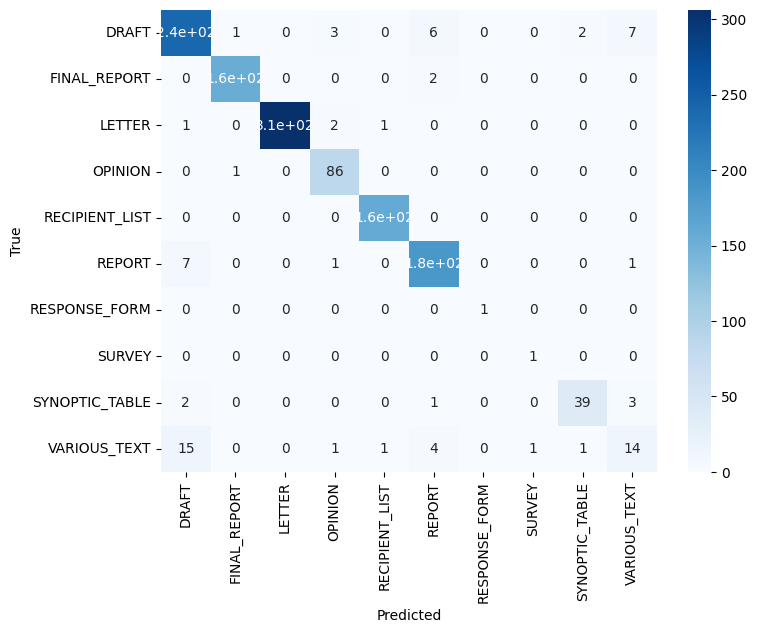

In [34]:
print(sklearn.metrics.classification_report(y_cv_test, cv_test_predictions))
display(plotting.plot_confusion_matrix_heatmap(y_cv_test, cv_test_predictions))

### Feature importance

In [35]:
# explainer = shap.Explainer(classifier)  # .named_steps["logisticregression"])
# shap_values = explainer(X_cv_test)

# # visualize the first prediction's explanation
# shap.plots.waterfall(shap_values[0])


# def get_shap_values_for_complex_pipeline(pipeline, X_test):
#     # Extract preprocessing steps
#     column_transformer = pipeline.named_steps["columntransformer"]
#     classifier = pipeline.named_steps["logisticregression"]

#     # Transform a small batch of data for initialization
#     background_indices = np.random.choice(X_test.shape[0], 100, replace=False)
#     background_data = column_transformer.transform(X_test[background_indices])

#     # Create explainer with both model and background data
#     explainer = shap.KernelExplainer(classifier.predict, background_data)

#     # Transform the full test data
#     transformed_data = column_transformer.transform(X_test)

#     # Get SHAP values
#     shap_values = explainer.shap_values(transformed_data)

#     return shap_values


# Usage
# shap_values = get_shap_values_for_complex_pipeline(classifier, X_cv_test)
# shap_values


In [36]:
# importances = pd.Series(
#     classifier.named_steps["gradientboostingclassifier"].feature_importances_,
#     index=[f"embedding_{i:02d}" for i in range(20)] + extra_feature_columns,
# )
# importances.sort_values(ascending=False)

***

## Evaluation on the test set (USE SPARINGLY)

2025/03/04 17:52:16 WARNING mlflow.sklearn: Failed to log training dataset information to MLflow Tracking. Reason: 'Series' object has no attribute 'flatten'
2025/03/04 17:52:39 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


docs: ground truth (1387,)
docs: predictions (1387,)
                precision    recall  f1-score   support

         DRAFT       0.92      0.94      0.93       288
  FINAL_REPORT       0.98      0.98      0.98       175
        LETTER       1.00      0.99      1.00       344
       OPINION       0.94      0.93      0.93        97
RECIPIENT_LIST       0.99      1.00      1.00       176
        REPORT       0.93      0.95      0.94       214
 RESPONSE_FORM        nan      0.00      0.00         1
        SURVEY       0.00      0.00      0.00         1
SYNOPTIC_TABLE       0.82      0.82      0.82        50
  VARIOUS_TEXT       0.45      0.34      0.39        41

      accuracy                           0.94      1387
     macro avg       0.78      0.70      0.70      1387
  weighted avg       0.94      0.94      0.94      1387



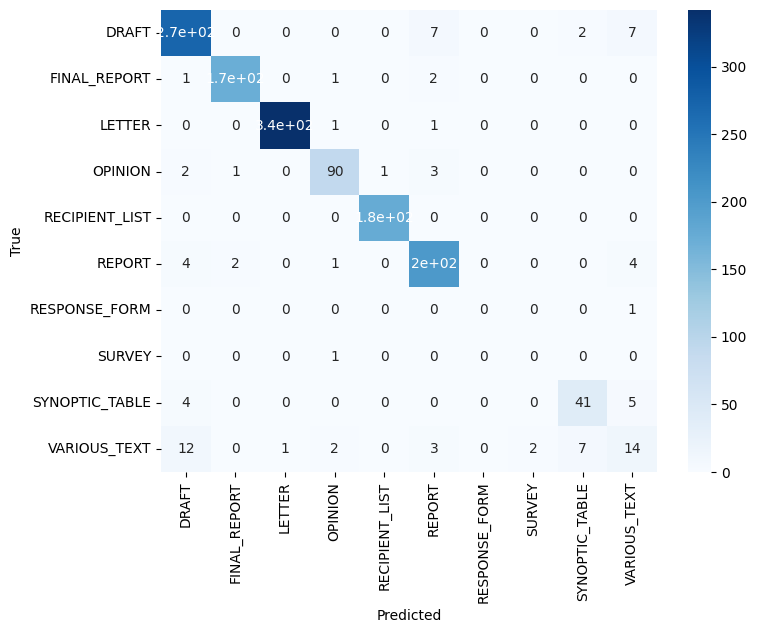

{'test_accuracy': 0.9437635183850036,
 'test_top_k_accuracy': 0.9790915645277577,
 'test_precision': 0.9410895969942886,
 'test_recall': 0.9437635183850036,
 'test_f1': 0.9418096560889604}

In [37]:
if USE_TEST_SET:
    classifier_test = create_classifier()
    classifier_test.fit(X_train, y_train)
    test_ground_truth_docs = y_test
    test_predictions_docs = classifier_test.predict(X_test)

    print("docs: ground truth", test_ground_truth_docs.shape)
    print("docs: predictions", test_predictions_docs.shape)

    print(
        sklearn.metrics.classification_report(
            test_ground_truth_docs,
            test_predictions_docs,
            zero_division=np.nan,
        )
    )
    display(plotting.plot_confusion_matrix_heatmap(test_ground_truth_docs, test_predictions_docs))

    test_metrics = {
        "test_accuracy": sklearn.metrics.accuracy_score(test_ground_truth_docs, test_predictions_docs),
        "test_top_k_accuracy": sklearn.metrics.top_k_accuracy_score(
            test_ground_truth_docs, classifier_test.predict_proba(X_test)
        ),
    }
    test_metrics["test_precision"], test_metrics["test_recall"], test_metrics["test_f1"], _ = (
        sklearn.metrics.precision_recall_fscore_support(
            test_ground_truth_docs,
            test_predictions_docs,
            average="weighted",
            zero_division=np.nan,
        )
    )
    display(test_metrics)
    mlflow.log_metrics(test_metrics)

***

# Rule-based & ML model evaluation

## Embed the OpenParlData test set

In [38]:
tokens_opd_test = df_opd_test["document_content_plain"].progress_map(embedding_model.tokenize)

with embeddings.use_cache(
    embedding_model,
    tqdm=tqdm,
    cache_directory=REPOSITORY_ROOT / "data" / "embeddings-cache",
    read_only=False,
) as get_embeddings:
    embeddings_opd_test = get_embeddings(tokens_opd_test.tolist())
    print(embeddings_opd_test.shape)

Embedding (cached=5836, new=0): 100%|██████████| 5837/5837 [00:05<00:00, 1100.72it/s]


(5837, 3072)


In [39]:
df_opd_test["embedding"] = embeddings_opd_test.tolist()

## Merge classes in the test set

In [40]:
df_opd_test["document_type"] = merge_classes(df_opd_test["document_type"])

## Test both the rule-based model and the sklearn model on a sample of OpenParlData

In [41]:
# Option A: random sample
# sample_batch = df_opd_test.sample(10)

# Option B: Use the same sample batch for now: the one where we've manually added ground truth labels
# Unfortunately, our training data may be missing some document types that we labelled in the external test set:
valid_external_test_document_ids = df_test_external[
    df_test_external["ground_truth"].isin(df_input["document_type"].unique())
].index
sample_batch = df_opd_test[df_opd_test["document_id"].isin(valid_external_test_document_ids)].copy()
print(len(sample_batch))

106


Use both models to generate predictions:

In [42]:
X_sample_batch = np.hstack(
    (
        np.array(sample_batch["embedding"].tolist()),
        sample_batch[extra_feature_columns].fillna(0),
        sample_batch[extra_categorical_feature_columns],
    )
)
X_sample_batch.shape

(106, 3078)

In [43]:
sample_batch["prediction_rule"] = merge_classes(document_title_rule_model.predict(sample_batch))

sample_batch["prediction_ml"] = classifier.predict(X_sample_batch)
sample_batch["prediction_ml_proba"] = classifier.predict_proba(X_sample_batch).tolist()

(Sample option A only) Copy the sample to the clipboard...

In [44]:
# sample_batch[["document_id", "document_source_url", "document_title"]].to_clipboard(index=False)

(Sample option A only)  ...after adding the true labels, run this to load them back in here:

In [45]:
# ground_truth = pd.read_excel(REPOSITORY_ROOT / "research" / "document_types" / "ground_truth.xlsx")[
#     ["document_id", "ground_truth"]
# ].set_index("document_id")

### Display all samples

In [46]:
sample_batch_with_ground_truth = sample_batch.join(df_test_external, on="document_id")

sample_batch_with_ground_truth[
    [
        "document_id",
        "political_body",
        "consultation_url",
        "document_source_url",
        "document_title",
        "ground_truth",
        "prediction_rule",
        "prediction_ml",
    ]
].style.format(
    {
        "consultation_url": lambda x: f'<a href="{x}">vnl</a>',
        "document_source_url": lambda x: f'<a href="{x}">doc</a>',
    }
).set_table_styles([{"selector": "th,td", "props": [("text-align", "left")]}])

,document_id,political_body,consultation_url,document_source_url,document_title,ground_truth,prediction_rule,prediction_ml
39623,39759,ai,vnl,doc,Entwurf Verordnung über die Nutzung des Untergrundes (VNU),DRAFT,DRAFT,DRAFT
39624,39760,ai,vnl,doc,Erläuternder Bericht zum Entwurf für ein Gesetz über die Nutzung des Untergrundes (GNU),REPORT,REPORT,REPORT
39706,39842,ai,vnl,doc,Entwurf Landsgemeindebeschluss über die Revision der Gerichtsorganisationsbestimmungen,DRAFT,DRAFT,DRAFT
39752,39888,ar,vnl,doc,Synopse,SYNOPTIC_TABLE,SYNOPTIC_TABLE,SYNOPTIC_TABLE
39761,39897,ar,vnl,doc,Liste der Vernehmlassungsadressaten,RECIPIENT_LIST,RECIPIENT_LIST,RECIPIENT_LIST
39769,39905,ar,vnl,doc,Erläuternder Bericht,REPORT,REPORT,REPORT
39779,39915,ar,vnl,doc,Begleitschreiben Vernehmlassung,LETTER,LETTER,LETTER
39917,40053,ar,vnl,doc,erläuternder Bericht,REPORT,REPORT,REPORT
39927,40063,ar,vnl,doc,Synopse,SYNOPTIC_TABLE,SYNOPTIC_TABLE,SYNOPTIC_TABLE
39931,40067,ar,vnl,doc,Glossar,VARIOUS_TEXT,nan,VARIOUS_TEXT


In [47]:
# sample_batch.loc[sample_batch["document_id"] == 47461, "document_content_plain"].values[0]

In [48]:
sample_batch_with_ground_truth["ground_truth"].value_counts(dropna=False)

ground_truth
REPORT            29
DRAFT             24
LETTER            13
SYNOPTIC_TABLE    13
RECIPIENT_LIST     8
FINAL_REPORT       8
VARIOUS_TEXT       8
RESPONSE_FORM      2
OPINION            1
LINK               0
DECISION           0
SURVEY             0
Name: count, dtype: int64

### ML model vs. ground truth

In [49]:
external_test_precision, external_test_recall, external_test_f1, _ = sklearn.metrics.precision_recall_fscore_support(
    sample_batch_with_ground_truth["ground_truth"],
    sample_batch_with_ground_truth["prediction_ml"],
    average="weighted",
    zero_division=np.nan,
)
mlflow.log_metrics(
    _m := {
        "external_test_accuracy": sklearn.metrics.accuracy_score(
            sample_batch_with_ground_truth["ground_truth"], sample_batch_with_ground_truth["prediction_ml"]
        ),
        "external_test_top_k_accuracy": sklearn.metrics.top_k_accuracy_score(
            sample_batch_with_ground_truth["ground_truth"],
            np.array(sample_batch_with_ground_truth["prediction_ml_proba"].tolist()),
            labels=sklearn.utils.multiclass.unique_labels(
                df_input_train["document_type"], sample_batch_with_ground_truth["ground_truth"]
            ),
        ),
        "external_test_precision": external_test_precision,
        "external_test_recall": external_test_recall,
        "external_test_f1": external_test_f1,
    }
)
_m

{'external_test_accuracy': 0.7452830188679245,
 'external_test_top_k_accuracy': 0.839622641509434,
 'external_test_precision': 0.8373724192474192,
 'external_test_recall': 0.7452830188679245,
 'external_test_f1': 0.7540894874997335}

In [50]:
print(
    sklearn.metrics.classification_report(
        sample_batch_with_ground_truth["ground_truth"],
        sample_batch_with_ground_truth["prediction_ml"],
        zero_division=np.nan,
    )
)

                precision    recall  f1-score   support

         DRAFT       0.86      0.75      0.80        24
  FINAL_REPORT       0.75      0.38      0.50         8
        LETTER       0.87      1.00      0.93        13
       OPINION       0.12      1.00      0.22         1
RECIPIENT_LIST       1.00      0.88      0.93         8
        REPORT       0.91      0.69      0.78        29
 RESPONSE_FORM        nan      0.00      0.00         2
SYNOPTIC_TABLE       0.52      1.00      0.68        13
  VARIOUS_TEXT       1.00      0.50      0.67         8

      accuracy                           0.75       106
     macro avg       0.75      0.69      0.61       106
  weighted avg       0.84      0.75      0.75       106



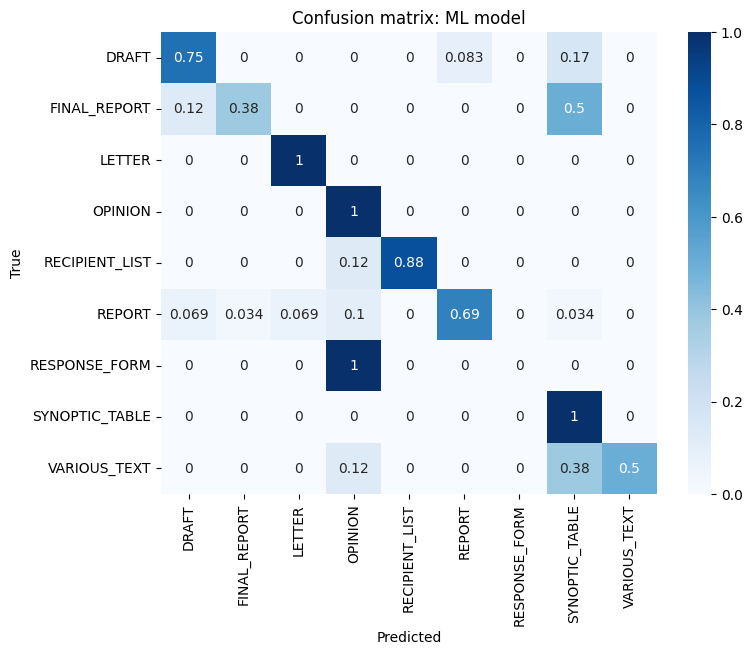

In [51]:
plotting.plot_confusion_matrix_heatmap(
    sample_batch_with_ground_truth["ground_truth"],
    sample_batch_with_ground_truth["prediction_ml"],
    title="ML model",
    normalize="true",
)

### Rule-based model vs. ground truth

In [52]:
_df = sample_batch_with_ground_truth[sample_batch_with_ground_truth["prediction_rule"].notna()]
print(sklearn.metrics.classification_report(_df["ground_truth"], _df["prediction_rule"], zero_division=np.nan))

                precision    recall  f1-score   support

         DRAFT       0.69      0.75      0.72        12
  FINAL_REPORT       1.00      0.33      0.50         6
        LETTER       1.00      1.00      1.00        12
       OPINION        nan      0.00      0.00         1
RECIPIENT_LIST       1.00      0.83      0.91         6
        REPORT       0.94      0.89      0.91        18
 RESPONSE_FORM       1.00      1.00      1.00         1
SYNOPTIC_TABLE       1.00      0.82      0.90        11
  VARIOUS_TEXT       0.20      1.00      0.33         2

      accuracy                           0.81        69
     macro avg       0.85      0.74      0.70        69
  weighted avg       0.91      0.81      0.83        69



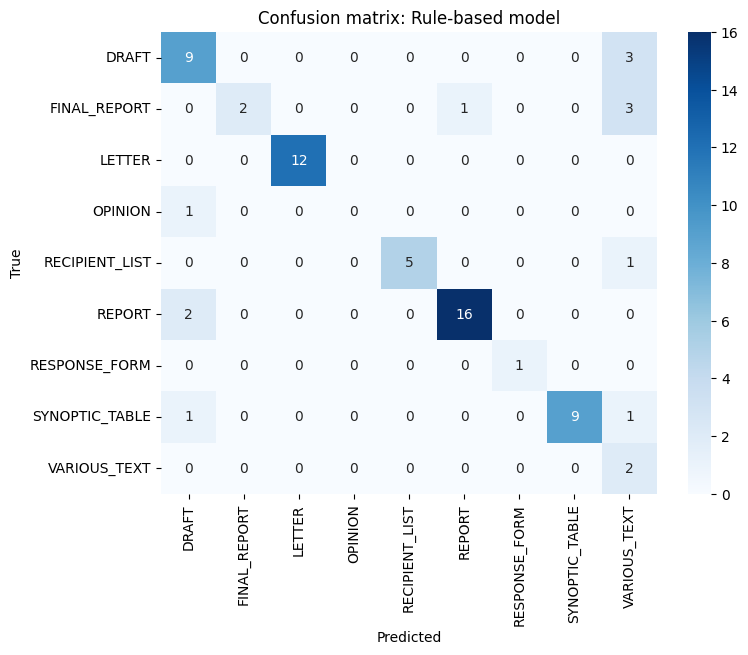

In [53]:
plotting.plot_confusion_matrix_heatmap(
    _df["ground_truth"],
    _df["prediction_rule"],
    title="Rule-based model",
    # normalize="true",
)

***

# End MLflow run

In [54]:
mlflow.end_run()

🏃 View run crawling-skunk-963 at: https://mlflow.ml1.demokratis.ch/#/experiments/2/runs/83dd7d26a71b498ea2851fee7b617cf1
🧪 View experiment at: https://mlflow.ml1.demokratis.ch/#/experiments/2
